# GRU neural network for traffic flow predictions
This notebook contains the code for applying neural network models to smart city data <br>


In [ ]:
# GPU check:

import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
print("Show System RAM Memory: \n \n")
!cat /proc/meminfo | egrep "MemTotal"
device_lib.list_local_devices()

Show System RAM Memory: 
 

MemTotal:       26751688 kB


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10599532133882647195, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14268427815692740287
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1931880630253188414
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15473775744
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7531200996911572395
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"]

Tutorial about google colab and GPU access: <br>
https://www.youtube.com/watch?v=f1UK8KPt-KU

In [ ]:
# this allows for accessing files stored in your google drive using the path "/gdrive/My Drive/"
# mounting google drive locally:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# importing local data to google colab:
from google.colab import files
uploaded = files.upload()

$\textbf{Background:}$ Tensors are data structures that you can think of as multi-dimensional arrays. Tensors are represented as n-dimensional arrays of base dataypes such as a string or integer -- they provide a way to generalize vectors and matrices to higher dimensions. The shape of a Tensor defines its number of dimensions and the size of each dimension. The rank of a Tensor provides the number of dimensions. Scalars can be used to create 0-d Tensors. Vectors and lists can be used to create 1-d Tensors. Matrices can be used to create 2-d or higher rank Tensors. The shape of a Tensor provides the number of elements in each Tensor dimension.

$\textbf{Neural Networks in Tensorflow:}$ We can also define neural networks in TensorFlow. TensorFlow uses a high-level API called Keras that provides a powerful, intuitive framework for building and training deep learning models. <br> 
Tensors can flow through abstract types called $\textit{Layers}$ -- the building blocks of neural networks. Layers implement common neural networks operations, and are used to update weights, compute losses, and define inter-layer connectivity <br>
<br>
Conveniently, TensorFlow has defined a number of Layers that are commonly used in neural networks, for example a Dense. Now, instead of using a single Layer to define our simple neural network, we'll use the Sequential model from Keras and a single Dense layer to define our network. With the Sequential API, you can readily create neural networks by stacking together layers like building blocks.

# Implementation

In [ ]:
## -- Packages  -- ##

# General
import pandas as pd
import numpy as np

# Time formatting
import datetime

# Load and save data
import pickle
# progress bar
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
#import tikzplotlib as tkz

In [ ]:
##  NN libaries ##
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt


## ML libraries ##
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler

In [ ]:
# setting the seed to create reproducible results
	
from numpy.random import seed
seed(123)
# setting the seed in tensorflow 2
tf.random.set_seed(123)

### Load data

In [ ]:
#load taxi data. Generated in notebook 'taxi_trips'
filename = '/gdrive/My Drive/Colab Notebooks/taxi_series_H'
infile = open(filename,'rb')
taxi_ts = pickle.load(infile)
infile.close()

In [ ]:
taxi_ts.shape

(8760,)

### Preprocessing

In [ ]:
## Remove last 24 hours as well as the part of test set not being used for main results
taxi_ts = taxi_ts.iloc[0:-192] 
taxi_ts.shape

(8568,)

In [ ]:
## Set paramaters
input_lags = 60 # 2 and a half times the seasonal period
output_lags = 24 # we predict 24 hours ahead
n_test = 24 # output_lags  (changed)


In [ ]:
## Split data in train and test set
train = taxi_ts[0:-n_test]
test = taxi_ts[-n_test:]
print(train.shape)
print(test.shape)

(8544,)
(24,)


In [ ]:
## Create lagged values for both input and output window (24)
data = train.copy()
n_train = len(data)

##Create lagged values for input
df = pd.DataFrame()
for i in range(input_lags,0,-1):
    df['t-' + str(i)] = data.shift(i)

##Create lagged values for output
for j in range(0,output_lags,1):
    df['t+' + str(j)] = data.shift(-j)
    
df = df[input_lags:(n_train-output_lags+1)]

In [ ]:
df.head()

,t-60,t-59,t-58,t-57,t-56,t-55,t-54,t-53,t-52,t-51,t-50,t-49,t-48,t-47,t-46,t-45,t-44,t-43,t-42,t-41,t-40,t-39,t-38,t-37,t-36,t-35,t-34,t-33,t-32,t-31,t-30,t-29,t-28,t-27,t-26,t-25,t-24,t-23,t-22,t-21,...,t-16,t-15,t-14,t-13,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t+0,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12,t+13,t+14,t+15,t+16,t+17,t+18,t+19,t+20,t+21,t+22,t+23
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-03 12:00:00,11510.0,9596.0,7984.0,5919.0,4414.0,2251.0,2725.0,3720.0,5547.0,8934.0,10842.0,12045.0,13286.0,14658.0,14261.0,13059.0,12673.0,14327.0,13896.0,12740.0,11350.0,11197.0,9885.0,8741.0,4915.0,2747.0,1652.0,1173.0,1318.0,2682.0,6690.0,9618.0,12715.0,13279.0,12110.0,12133.0,13245.0,14139.0,14624.0,14278.0,...,12759.0,12897.0,11317.0,8075.0,4866.0,2737.0,1587.0,1156.0,1172.0,2520.0,6333.0,9554.0,12878.0,13005.0,12508.0,12509.0,14326,16733.0,15450.0,14738.0,14632.0,16585.0,16488.0,12862.0,11051.0,11540.0,11029.0,10140.0,8339.0,6441.0,4764.0,3385.0,2489.0,1651.0,2388.0,3018.0,3847.0,5269.0,6621.0,8176.0
2018-07-03 13:00:00,9596.0,7984.0,5919.0,4414.0,2251.0,2725.0,3720.0,5547.0,8934.0,10842.0,12045.0,13286.0,14658.0,14261.0,13059.0,12673.0,14327.0,13896.0,12740.0,11350.0,11197.0,9885.0,8741.0,4915.0,2747.0,1652.0,1173.0,1318.0,2682.0,6690.0,9618.0,12715.0,13279.0,12110.0,12133.0,13245.0,14139.0,14624.0,14278.0,13545.0,...,12897.0,11317.0,8075.0,4866.0,2737.0,1587.0,1156.0,1172.0,2520.0,6333.0,9554.0,12878.0,13005.0,12508.0,12509.0,14326.0,16733,15450.0,14738.0,14632.0,16585.0,16488.0,12862.0,11051.0,11540.0,11029.0,10140.0,8339.0,6441.0,4764.0,3385.0,2489.0,1651.0,2388.0,3018.0,3847.0,5269.0,6621.0,8176.0,9131.0
2018-07-03 14:00:00,7984.0,5919.0,4414.0,2251.0,2725.0,3720.0,5547.0,8934.0,10842.0,12045.0,13286.0,14658.0,14261.0,13059.0,12673.0,14327.0,13896.0,12740.0,11350.0,11197.0,9885.0,8741.0,4915.0,2747.0,1652.0,1173.0,1318.0,2682.0,6690.0,9618.0,12715.0,13279.0,12110.0,12133.0,13245.0,14139.0,14624.0,14278.0,13545.0,14945.0,...,11317.0,8075.0,4866.0,2737.0,1587.0,1156.0,1172.0,2520.0,6333.0,9554.0,12878.0,13005.0,12508.0,12509.0,14326.0,16733.0,15450,14738.0,14632.0,16585.0,16488.0,12862.0,11051.0,11540.0,11029.0,10140.0,8339.0,6441.0,4764.0,3385.0,2489.0,1651.0,2388.0,3018.0,3847.0,5269.0,6621.0,8176.0,9131.0,10124.0
2018-07-03 15:00:00,5919.0,4414.0,2251.0,2725.0,3720.0,5547.0,8934.0,10842.0,12045.0,13286.0,14658.0,14261.0,13059.0,12673.0,14327.0,13896.0,12740.0,11350.0,11197.0,9885.0,8741.0,4915.0,2747.0,1652.0,1173.0,1318.0,2682.0,6690.0,9618.0,12715.0,13279.0,12110.0,12133.0,13245.0,14139.0,14624.0,14278.0,13545.0,14945.0,16542.0,...,8075.0,4866.0,2737.0,1587.0,1156.0,1172.0,2520.0,6333.0,9554.0,12878.0,13005.0,12508.0,12509.0,14326.0,16733.0,15450.0,14738,14632.0,16585.0,16488.0,12862.0,11051.0,11540.0,11029.0,10140.0,8339.0,6441.0,4764.0,3385.0,2489.0,1651.0,2388.0,3018.0,3847.0,5269.0,6621.0,8176.0,9131.0,10124.0,9832.0
2018-07-03 16:00:00,4414.0,2251.0,2725.0,3720.0,5547.0,8934.0,10842.0,12045.0,13286.0,14658.0,14261.0,13059.0,12673.0,14327.0,13896.0,12740.0,11350.0,11197.0,9885.0,8741.0,4915.0,2747.0,1652.0,1173.0,1318.0,2682.0,6690.0,9618.0,12715.0,13279.0,12110.0,12133.0,13245.0,14139.0,14624.0,14278.0,13545.0,14945.0,16542.0,14673.0,...,4866.0,2737.0,1587.0,1156.0,1172.0,2520.0,6333.0,9554.0,12878.0,13005.0,12508.0,12509.0,14326.0,16733.0,15450.0,14738.0,14632,16585.0,16488.0,12862.0,11051.0,11540.0,11029.0,10140.0,8339.0,6441.0,4764.0,3385.0,2489.0,1651.0,2388.0,3018.0,3847.0,5269.0,6621.0,8176.0,9131.0,10124.0,9832.0,9478.0


In [ ]:
## splitting the training set into labels and features
X_train = df.iloc[:,:input_lags] # from the beginning to input_lags
Y_train = df.iloc[:,input_lags:] # from input_lags to the end

## Use the last window of the training set as the features for the test set. This requires a combination of 
## X_train and Y_train.
X_test = X_train.iloc[len(X_train) - 1,:][output_lags:]
X_test = X_test.append(Y_train.iloc[len(Y_train) - 1,:]).values.reshape(1,input_lags)
Y_test = test[:output_lags].values.reshape(1,output_lags)

X_train = X_train.values # 54 steps back (54 lags)
Y_train = Y_train.values # 24 steps ahead

print("X_train: " + "type: " + str(type(X_train)) + "\tshape: " + str(X_train.shape))
print("Y_train: " + "type: " + str(type(Y_train)) + "\tshape: " + str(Y_train.shape))
print("X_test: " + "type: " + str(type(X_test)) + "\tshape: " + str(X_test.shape))
print("Y_test: " + "type: " + str(type(Y_test)) + "\tshape: " + str(Y_test.shape))

X_train: type: <class 'numpy.ndarray'>	shape: (8461, 60)
Y_train: type: <class 'numpy.ndarray'>	shape: (8461, 24)
X_test: type: <class 'numpy.ndarray'>	shape: (1, 60)
Y_test: type: <class 'numpy.ndarray'>	shape: (1, 24)


$\textbf{When Should You Use Normalization And Standardization:}$

Normalization is a good technique to use when you do not know the distribution of your data or when you know the distribution is not Gaussian (a bell curve). Normalization is useful when your data has varying scales and the algorithm you are using does not make assumptions about the distribution of your data, such as k-nearest neighbors and artificial neural networks.

In [ ]:
## normalizing the data

# MinMaxScaler() transforms features by scaling each feature to a given range (given by feature_range())
# The cost of having this bounded range is that we will end up with smaller standard deviations, which can 
# suppress the effect of outliers. Thus MinMax Scalar is sensitive to outliers

#scaler = MinMaxScaler(feature_range=(0, 1))
#df_x = df.iloc[:,0:24]
# the method fit_transform() computes the min and the max used for scaling and then carries out the transformation
#df_x_scaled = scaler.fit_transform(df_x)
# later, inverse_transform() can be used to undo the scaling to the feature_range

# normalizing the entire dataset
#df_normalized = scaler.fit_transform(df)

# Building the GRU neural network model

# Method 1 (Keras)

Tensorflow 2.0 Impelementation <br>
(tf.keras is TensorFlow's implementation of the Keras API specification. This is a high-level API to build and train models that includes first-class support for TensorFlow-specific functionality)


TF 2 keras RNN tutorial
https://www.tensorflow.org/guide/keras/rnn <br>
TF 2 time series forecasting tutorial
https://www.tensorflow.org/tutorials/structured_data/time_series

In [ ]:
# configuring the inputs for the model
# For Keras, the input has to be in the shape (samples, time steps, features)
# 24 timestep with n features where n is equal to the shape of column [1] of X_train or X_test

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
X_train.shape

(8461, 1, 60)

In [ ]:
X_test.shape

(1, 1, 60)

In [ ]:
# creating a leaky_relu activation function

def my_leaky_relu(x):
    return tf.nn.leaky_relu(x)

## Gridsearch CV for the optimal hyperparameters

Guide to Hyperparameter tuning: <br>
https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594
Dropout regularization for RNNs: <br>
https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/

## One step Gridsearch CV for all hyperparameters

**Blogpost Hyperparametertuning LSTM/GRU:**

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

**Overview of Gradient Descent Algorithms:**

https://ruder.io/optimizing-gradient-descent/index.html#adagrad

In [ ]:
# creating the parameter grid as a dictionary (new grid)

## FULL GRID ##
batch_size = [100, 250, 500]
epochs = [250, 500, 750]
neurons = [500, 1000, 1500]
dropout = [0.0]
learning_rate = [0.001, 0.01]
optimizer = ['Adagrad', 'Adam', 'Adadelta']

param_grid_cv = dict(batch_size=batch_size, epochs=epochs, neurons=neurons, dropout = dropout, optimizer=optimizer, learning_rate = learning_rate)

In [ ]:
## REDUCED GRID ##
batch_size = [200, 300]
epochs = [200, 300]
neurons = [500, 1000, 1500]
dropout = [0.0, 0.2]
learning_rate = [0.001]

param_grid_cv = dict(batch_size=batch_size, epochs=epochs, neurons=neurons, dropout = dropout, learning_rate = learning_rate)
# fixed learning rate at 0.001 seems to work best, "leaky relu" activation function seems to work best, dropout seems to lower the test error

In [ ]:
# setting up the model (1 HL)
# the default activation function is tanh()

def model(neurons = 128, epochs = 100, batch_size =100, dropout = 0.0, learning_rate = 0.001, optimizer="Adam"):
    model = tf.keras.Sequential()

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
    model.add(tf.keras.layers.GRU(units=neurons, return_sequences = False, input_shape = (1,60), dropout = dropout, activation = my_leaky_relu))

# output layer with 24 neurons
    model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
    
    #model.summary()
    return model


In [ ]:
# setting up the model (2 HL)
# the default activation function is tanh()

def model(neurons = 128, epochs = 100, batch_size =100, dropout = 0.0, learning_rate = 0.001, optimizer="Adam"):
    model = tf.keras.Sequential()

# embedding layer expecting input dimension of size 1000 and an output dimension of size 64.
# i.e. the model will take as input an integer matrix of size (batch_size, input_length)
# and it will turn positive integers (indexes) into dense vectors of fixed size.
#model.add(tf.keras.layers.Embedding(input_dim=1000, output_dim=64))

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
    model.add(tf.keras.layers.GRU(units=neurons, return_sequences = True, input_shape = (1,60), dropout = dropout, activation = my_leaky_relu))

    model.add(tf.keras.layers.GRU(units=neurons, return_sequences = False, input_shape = (1,60), dropout = dropout, activation = my_leaky_relu))

# output layer with 24 neurons
    model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
    
    #model.summary()
    return model


In [ ]:
# setting up the model for the GSCV (3 HL)
# the default activation function is tanh()

def model(neurons = 128, epochs = 100, batch_size =100, dropout = 0.0, learning_rate = 0.001, optimizer="Adam"):
    model = tf.keras.Sequential()

# embedding layer expecting input dimension of size 1000 and an output dimension of size 64.
# i.e. the model will take as input an integer matrix of size (batch_size, input_length)
# and it will turn positive integers (indexes) into dense vectors of fixed size.
#model.add(tf.keras.layers.Embedding(input_dim=1000, output_dim=64))

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
    model.add(tf.keras.layers.GRU(units=neurons, return_sequences = True, input_shape = (1,60), dropout = dropout, activation = my_leaky_relu))

    model.add(tf.keras.layers.GRU(units=neurons, return_sequences = True, input_shape = (1,60), dropout = dropout, activation = my_leaky_relu))

    model.add(tf.keras.layers.GRU(units=neurons, return_sequences = False, input_shape = (1,60), dropout = dropout, activation = my_leaky_relu))

# output layer with 24 neurons
    model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
    
    #model.summary()
    return model

In [ ]:
# using the KerasRegressor as a wrapper to carry out the GridSearchCV
model_cv = KerasRegressor(build_fn = model, verbose=1)

In [ ]:
# new grid 3 fold CV (Aug 27) 1 HL
inner_splits = 3
inner_loop = TimeSeriesSplit(n_splits = inner_splits).split(X_train,Y_train)

# n_jobs set to 4 means that 4 cores are used for parallel processing; set n_jobs=-1 to use all available cores
# default for scoring in the gridsearchCV is none and the loss of the estimator is used

grid_cv = GridSearchCV(estimator = model_cv, param_grid = param_grid_cv, cv = inner_loop, verbose = 3, n_jobs=-1, scoring="neg_mean_squared_error")
grid_result = grid_cv.fit(X_train,Y_train)


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 11.1min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 88.5min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 182.6min


[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed: 251.6min finished


Epoch 1/500
85/85 [==============================] - 0s 5ms/step - loss: 14153372.0000 - mean_squared_error: 14153372.0000
Epoch 2/500
85/85 [==============================] - 0s 5ms/step - loss: 6185089.0000 - mean_squared_error: 6185089.0000
Epoch 3/500
85/85 [==============================] - 0s 5ms/step - loss: 5173280.0000 - mean_squared_error: 5173280.0000
Epoch 4/500
85/85 [==============================] - 0s 5ms/step - loss: 4527319.5000 - mean_squared_error: 4527319.5000
Epoch 5/500
85/85 [==============================] - 0s 5ms/step - loss: 4178963.7500 - mean_squared_error: 4178963.7500
Epoch 6/500
85/85 [==============================] - 0s 5ms/step - loss: 3908328.5000 - mean_squared_error: 3908328.5000
Epoch 7/500
85/85 [==============================] - 0s 5ms/step - loss: 3666671.7500 - mean_squared_error: 3666671.7500
Epoch 8/500
85/85 [==============================] - 0s 5ms/step - loss: 3518899.2500 - mean_squared_error: 3518899.2500
Epoch 9/500
85/85 [===========

In [ ]:
# summarize results new grid (Aug 27)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -2178115.059765 using {'batch_size': 100, 'dropout': 0.0, 'epochs': 500, 'learning_rate': 0.001, 'neurons': 1500, 'optimizer': 'Adam'}
-2574146.789973 (1082074.273960) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 500, 'optimizer': 'Adagrad'}
-2654551.529501 (1167826.975907) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 500, 'optimizer': 'Adam'}
-2459949.538424 (998634.916763) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 500, 'optimizer': 'Adadelta'}
-2384253.579684 (870141.570461) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 1000, 'optimizer': 'Adagrad'}
-2398398.400121 (932045.188981) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 1000, 'optimizer': 'Adam'}
-2368473.546301 (868969.535308) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learn

In [ ]:
# new grid 3 fold CV (2H layer)
inner_splits = 3
inner_loop = TimeSeriesSplit(n_splits = inner_splits).split(X_train,Y_train)

# n_jobs set to 4 means that 4 cores are used for parallel processing; set n_jobs=-1 to use all available cores
# default for scoring in the gridsearchCV is none and the loss of the estimator is used

grid_cv = GridSearchCV(estimator = model_cv, param_grid = param_grid_cv, cv = inner_loop, verbose = 3, n_jobs=-1, scoring="neg_mean_squared_error")
grid_result = grid_cv.fit(X_train,Y_train)


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 27.3min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 228.7min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 480.4min


In [ ]:
# summarize results new grid (2h layer)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -2155048.068026 using {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 1000, 'optimizer': 'Adadelta'}
-2199560.959031 (888706.003463) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 500, 'optimizer': 'Adagrad'}
-2333510.360810 (842961.795462) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 500, 'optimizer': 'Adam'}
-2266778.417670 (939695.019457) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 500, 'optimizer': 'Adadelta'}
-2264204.653604 (804698.846848) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 1000, 'optimizer': 'Adagrad'}
-2327887.873729 (806219.132850) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 1000, 'optimizer': 'Adam'}
-2155048.068026 (868209.646494) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'lea

##GSCV (August 27, 2020)
Best: -2178115.059765 using {'batch_size': 100, 'dropout': 0.0, 'epochs': 500, 'learning_rate': 0.001, 'neurons': 1500, 'optimizer': 'Adam'}

## Fitting the optimal model with all gridsearched parameters

GRU with 1 HL

In [ ]:


# fitting the optimal GRU model with the gridsearched hyperparameters (1HL)
GRU_model = tf.keras.Sequential()

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
GRU_model.add(tf.keras.layers.GRU(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))


# output layer 
GRU_model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
GRU_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
GRU_model.fit(X_train, Y_train, epochs=500, batch_size=100, verbose=1)
    


Epoch 1/500
85/85 [==============================] - 0s 5ms/step - loss: 13365004.0000 - mean_squared_error: 13365004.0000
Epoch 2/500
85/85 [==============================] - 0s 5ms/step - loss: 6102575.5000 - mean_squared_error: 6102575.5000
Epoch 3/500
85/85 [==============================] - 0s 5ms/step - loss: 5045640.0000 - mean_squared_error: 5045640.0000
Epoch 4/500
85/85 [==============================] - 0s 5ms/step - loss: 4443422.5000 - mean_squared_error: 4443422.5000
Epoch 5/500
85/85 [==============================] - 0s 5ms/step - loss: 4115023.2500 - mean_squared_error: 4115023.2500
Epoch 6/500
85/85 [==============================] - 0s 5ms/step - loss: 3872245.2500 - mean_squared_error: 3872245.0000
Epoch 7/500
85/85 [==============================] - 0s 5ms/step - loss: 3682006.5000 - mean_squared_error: 3682007.0000
Epoch 8/500
85/85 [==============================] - 0s 5ms/step - loss: 3476414.7500 - mean_squared_error: 3476414.7500
Epoch 9/500
85/85 [===========

In [ ]:
GRU_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1500)              7029000   
_________________________________________________________________
dense (Dense)                (None, 24)                36024     
Total params: 7,065,024
Trainable params: 7,065,024
Non-trainable params: 0
_________________________________________________________________


Deep GRU network (input layer - 2 stacked GRU hidden layers - output layer)


In [ ]:
# To stack GRU layers, we need to change the configuration of the prior GRU layer to output a 3D array as input for the subsequent layer.
# We can do this by setting the return_sequences argument on the layer to True (the default is False). 
# This will return one output for each input time step and provide a 3D array.

# fitting the optimal GRU model with the gridsearched hyperparameters
Deep_GRU_model = tf.keras.Sequential()

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
Deep_GRU_model.add(tf.keras.layers.GRU(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 2nd GRU hidden layer
Deep_GRU_model.add(tf.keras.layers.GRU(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))


# output layer with a number of neurons equal to the forecast horizon
Deep_GRU_model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
Deep_GRU_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
Deep_GRU_model.fit(X_train, Y_train, epochs=500, batch_size=100, verbose=1)



Epoch 1/500
85/85 [==============================] - 1s 10ms/step - loss: 11647140.0000 - mean_squared_error: 11647140.0000
Epoch 2/500
85/85 [==============================] - 1s 10ms/step - loss: 4735408.5000 - mean_squared_error: 4735408.5000
Epoch 3/500
85/85 [==============================] - 1s 10ms/step - loss: 3927155.2500 - mean_squared_error: 3927155.2500
Epoch 4/500
85/85 [==============================] - 1s 10ms/step - loss: 3455267.2500 - mean_squared_error: 3455267.2500
Epoch 5/500
85/85 [==============================] - 1s 10ms/step - loss: 3177919.2500 - mean_squared_error: 3177919.2500
Epoch 6/500
85/85 [==============================] - 1s 10ms/step - loss: 2874930.2500 - mean_squared_error: 2874930.2500
Epoch 7/500
85/85 [==============================] - 1s 10ms/step - loss: 2718487.5000 - mean_squared_error: 2718487.5000
Epoch 8/500
85/85 [==============================] - 1s 10ms/step - loss: 2685432.7500 - mean_squared_error: 2685432.7500
Epoch 9/500
85/85 [===

Deep GRU network (input layer - 3 stacked GRU layers - output layer)

In [ ]:
# To stack GRU layers, we need to change the configuration of the prior GRU layer to output a 3D array as input for the subsequent layer.
# We can do this by setting the return_sequences argument on the layer to True (the default is False). 
# This will return one output for each input time step and provide a 3D array.

# fitting the optimal GRU model with the gridsearched hyperparameters
Deep_GRU_model2 = tf.keras.Sequential()

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
Deep_GRU_model2.add(tf.keras.layers.GRU(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 2nd GRU hidden layer
Deep_GRU_model2.add(tf.keras.layers.GRU(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 3rd GRU hidden layer
Deep_GRU_model2.add(tf.keras.layers.GRU(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))


# output layer with a number of neurons equal to the forecast horizon
Deep_GRU_model2.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
Deep_GRU_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
Deep_GRU_model2.fit(X_train, Y_train, epochs=500, batch_size=100, verbose=1)

Epoch 1/500
85/85 [==============================] - 1s 13ms/step - loss: 15024950.0000 - mean_squared_error: 15024951.0000
Epoch 2/500
85/85 [==============================] - 1s 13ms/step - loss: 4903237.5000 - mean_squared_error: 4903237.5000
Epoch 3/500
85/85 [==============================] - 1s 13ms/step - loss: 3965965.2500 - mean_squared_error: 3965965.2500
Epoch 4/500
85/85 [==============================] - 1s 13ms/step - loss: 3605331.5000 - mean_squared_error: 3605331.5000
Epoch 5/500
85/85 [==============================] - 1s 13ms/step - loss: 3094846.5000 - mean_squared_error: 3094846.5000
Epoch 6/500
85/85 [==============================] - 1s 13ms/step - loss: 2621645.2500 - mean_squared_error: 2621645.0000
Epoch 7/500
85/85 [==============================] - 1s 13ms/step - loss: 2476057.7500 - mean_squared_error: 2476057.7500
Epoch 8/500
85/85 [==============================] - 1s 13ms/step - loss: 2331452.7500 - mean_squared_error: 2331453.0000
Epoch 9/500
85/85 [===

Deep GRU network (input layer - 5 stacked GRU layers - output layer)

In [ ]:
# To stack GRU layers, we need to change the configuration of the prior GRU layer to output a 3D array as input for the subsequent layer.
# We can do this by setting the return_sequences argument on the layer to True (the default is False). 
# This will return one output for each input time step and provide a 3D array.

# fitting the optimal GRU model with the gridsearched hyperparameters
Deep_GRU_model3 = tf.keras.Sequential()

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
Deep_GRU_model3.add(tf.keras.layers.GRU(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 2nd GRU hidden layer
Deep_GRU_model3.add(tf.keras.layers.GRU(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 3rd GRU hidden layer
Deep_GRU_model3.add(tf.keras.layers.GRU(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 4th GRU hidden layer
Deep_GRU_model3.add(tf.keras.layers.GRU(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 5th GRU hidden layer
Deep_GRU_model3.add(tf.keras.layers.GRU(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# output layer with a number of neurons equal to the forecast horizon
Deep_GRU_model3.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
Deep_GRU_model3.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate = 0.001),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
Deep_GRU_model3.fit(X_train, Y_train, epochs=500, batch_size=100, verbose=1)

Epoch 1/500
85/85 [==============================] - 3s 31ms/step - loss: 140748544.0000 - mean_squared_error: 140748544.0000
Epoch 2/500
85/85 [==============================] - 3s 30ms/step - loss: 140118192.0000 - mean_squared_error: 140118192.0000
Epoch 3/500
85/85 [==============================] - 3s 31ms/step - loss: 138701216.0000 - mean_squared_error: 138701216.0000
Epoch 4/500
85/85 [==============================] - 3s 31ms/step - loss: 131882472.0000 - mean_squared_error: 131882472.0000
Epoch 5/500
85/85 [==============================] - 3s 31ms/step - loss: 59590776.0000 - mean_squared_error: 59590776.0000
Epoch 6/500
85/85 [==============================] - 3s 31ms/step - loss: 25356112.0000 - mean_squared_error: 25356112.0000
Epoch 7/500
85/85 [==============================] - 3s 30ms/step - loss: 23592388.0000 - mean_squared_error: 23592388.0000
Epoch 8/500
85/85 [==============================] - 3s 31ms/step - loss: 21230866.0000 - mean_squared_error: 21230866.0000


## Undoing the normalization, making predictions and computing the test error

In [ ]:
# making predictions (regular GRU)
y_train_pred = GRU_model.predict(X_train)
y_test_pred = GRU_model.predict(X_test)

# making predictions (deep GRU 2 hidden layers)
y_train_pred_deep = Deep_GRU_model.predict(X_train)
y_test_pred_deep = Deep_GRU_model.predict(X_test)

# making predictions (deep GRU 3 hidden layers)
y_train_pred_deep3hl = Deep_GRU_model2.predict(X_train)
y_test_pred_deep3hl = Deep_GRU_model2.predict(X_test)

# making predictions (deep GRU 5 hidden layers)
y_train_pred_deep3 = Deep_GRU_model3.predict(X_train)
y_test_pred_deep3 = Deep_GRU_model3.predict(X_test)

Exporting the point forecasts

In [ ]:
GRU_preds = pd.Series(y_test_pred[0])
GRU_preds_deep = pd.Series(y_test_pred_deep[0])

In [ ]:
# export the GRU predictions and the test data to google drive
from google.colab import  drive

drive.mount('/drive')

GRU_preds.to_csv('/drive/My Drive/Colab Notebooks/GRU_preds.csv', index=False)
GRU_preds_deep.to_csv('/drive/My Drive/Colab Notebooks/GRU_preds_deep.csv', index=False)

Mounted at /drive


In [ ]:
# MSE GRU forecast
mse_GRU = mean_squared_error(Y_test, y_test_pred)
mse_GRU

366057.31891242415

In [ ]:
# RMSE GRU forecast
rmse_GRU = sqrt(mse_GRU)
rmse_GRU

605.0267092554049

In [ ]:
# mae GRU
mae_GRU = mean_absolute_error(Y_test, y_test_pred)
mae_GRU

523.342783610026

In [ ]:
# MSE Deep GRU forecast (2HL)
mse_GRU1 = mean_squared_error(Y_test, y_test_pred_deep)
mse_GRU1

319977.5437721138

In [ ]:
# RMSE Deep GRU forecast (2HL)
rmse_GRU1 = sqrt(mse_GRU1)
rmse_GRU1

565.6655759122291

In [ ]:
# mae DeepGRU (2HL)
mae_GRU1 = mean_absolute_error(Y_test, y_test_pred_deep)
mae_GRU1

461.5350646972656

In [ ]:
# MSE Deep GRU forecast (3HL)
mse_GRU3hl = mean_squared_error(Y_test, y_test_pred_deep3hl)
mse_GRU3hl

673890.4073348964

In [ ]:
# RMSE Deep GRU forecast (3HL)
rmse_GRU3hl = sqrt(mse_GRU3hl)
rmse_GRU3hl

820.9082819261214

In [ ]:
# mae DeepGRU (3HL)
mae_GRU3hl = mean_absolute_error(Y_test, y_test_pred_deep3hl)
mae_GRU3hl

688.857411702474

In [ ]:
# MSE Deep GRU forecast (5HL)
mse_GRU3 = mean_squared_error(Y_test, y_test_pred_deep3)
mse_GRU3

3161138.486491497

In [ ]:
# RMSE Deep GRU forecast (5HL)
rmse_GRU3 = sqrt(mse_GRU3)
rmse_GRU3

1777.9590789699005

In [ ]:
# mae DeepGRU (5HL)
mae_GRU2 = mean_absolute_error(Y_test, y_test_pred_deep3)
mae_GRU2

1541.4251759847004

In [ ]:
# custom MAPE function
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_true = Y_test
y_pred = y_test_pred_deep3hl



In [ ]:
y_pred = y_test_pred
# MAPE GRU 1 HL
mean_absolute_percentage_error(y_true,y_pred)

6.615520384512598

In [ ]:
# MAPE GRU 2 HL
mean_absolute_percentage_error(y_true,y_pred)

7.033227000109221

In [ ]:
# MAPE GRU 3 HL
y_true = Y_test
y_pred = y_test_pred_deep3hl

mean_absolute_percentage_error(y_true,y_pred)

8.01567038767401

## Prediction intervals using quantile regression

In [ ]:
# quantile regression loss = tilted loss = pinball loss
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

1 single PI network

In [ ]:
class GRU_PI_model(tf.keras.Model):
    def __init__(self, input_shape = (1,54), output_shape = 24, alpha = 0.95, batch_size = 200):
        super(GRU_PI_model, self).__init__()
        
        self.in_shape = input_shape
        self.out_shape = output_shape
        self.lower_alpha = (1-alpha)/2
        self.upper_alpha = (1-alpha)/2 + alpha
        self.batch_size = batch_size #move batch size to fit?
        
        self.loss_history = []
        
        ##define architechture 
        self.L1 = tf.keras.layers.GRU(units=1000, activation = my_leaky_relu, input_shape = (self.in_shape,None), dropout = 0.0, return_sequences= False)
        #self.L2 = tf.keras.layers.Dense(units =24, activation = "relu")
        self.output_lowerPI = tf.keras.layers.Dense(self.out_shape)
        self.output_upperPI = tf.keras.layers.Dense(self.out_shape)
        
        ##define optimizer
        self.train_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        
    def call(self, X): # use predict() for forward pass outside fit
        #X = tf.dtypes.cast(X, tf.float32) 
        
        X = self.L1(X)
        output_lowerPI = self.output_lowerPI(X) 
        output_upperPI = self.output_upperPI(X)
        
        combined_output = [output_lowerPI, output_upperPI]
        return combined_output
    
    def get_loss(self, X, Y):
        
        Y_hat = self.call(X)
        output_lowerPI = Y_hat[0]
        output_upperPI = Y_hat[1]
        
        error_lower = tf.subtract(Y, output_lowerPI)
        loss_lower = tf.math.reduce_mean(tf.math.maximum(self.lower_alpha * error_lower, (self.lower_alpha - 1) * error_lower))
        
        error_upper = tf.subtract(Y, output_upperPI)
        loss_upper = tf.math.reduce_mean(tf.math.maximum(self.upper_alpha * error_upper, (self.upper_alpha - 1) * error_upper))
        
        combined_loss = tf.add(loss_lower,loss_upper)
        return combined_loss
        
    def get_grad(self, X, Y):
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            L = self.get_loss(X, Y)
        g = tape.gradient(L, self.trainable_variables)
        
        return L, g    
    
    def train_step(self, X, Y):
        L, g = self.get_grad(X, Y)
    
        self.train_opt.apply_gradients(zip(g, self.trainable_variables))
        
        return L
        
    def fit(self, X, Y, epochs = 300): 
        X = tf.dtypes.cast(X, tf.float32) ##layers use float 32, so cast data to fit
        Y = tf.dtypes.cast(Y, tf.float32) ##layers use float 32, so cast data to fit
        
        if hasattr(tqdm, '_instances'): tqdm._instances.clear() ## clear load bar if it is not empty

        loadbar = tqdm(range(epochs)) ##define loadbar with loop range, which is number of epochs
        for epoch in loadbar:
            loadbar.set_description("Epoch {}".format(epoch + 1))
            
            batch_losses = []
            for idx in range(0, X.shape[0], self.batch_size): ## get batches of size batch_size. NOT shuffled
                batch_X = X[idx : min(idx + self.batch_size, X.shape[0]),:]
                batch_Y = Y[idx : min(idx + self.batch_size, Y.shape[0]),:]
                L = self.train_step(batch_X, batch_Y)
                batch_losses.append(L.numpy())
        
            epoch_loss = np.mean(batch_losses)
            self.loss_history.append(np.mean(batch_losses))

In [ ]:
model_95 = GRU_PI_model(input_shape =  (1,54), output_shape = 24, batch_size = 200, alpha = 0.95)

In [ ]:
model_95.fit(X_train, Y_train, epochs = 300)

Epoch 300: 100%|██████████| 300/300 [00:16<00:00, 18.46it/s]


In [ ]:
## make predictions and format them for plotting
predictions_95 = model_95.predict(X_test)
lower_PI_preds_95 = predictions_95[0]
upper_PI_preds_95 = predictions_95[1]


lower_PI_preds_95 = pd.Series(lower_PI_preds_95.reshape(output_lags,))
lower_PI_preds_95.index = test.iloc[:output_lags].index
upper_PI_preds_95 = pd.Series(upper_PI_preds_95.reshape(output_lags,))
upper_PI_preds_95.index = test.iloc[:output_lags].index


2 separate PI networks

PIs for 1 HL GRU

In [ ]:
## build lower bound with different loss (95% PI)
q = 0.025


# fitting the GRU model with the gridsearched hyperparameters
lower_PI_model = tf.keras.Sequential()

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
lower_PI_model.add(tf.keras.layers.GRU(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# output layer with 10 neurons
lower_PI_model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
lower_PI_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=lambda y,f: tilted_loss(q,y,f))
lower_PI_model.fit(X_train, Y_train, epochs=300, batch_size=200, verbose=1)


Epoch 1/300
43/43 [==============================] - 0s 5ms/step - loss: 168.1779
Epoch 2/300
43/43 [==============================] - 0s 5ms/step - loss: 130.8059
Epoch 3/300
43/43 [==============================] - 0s 5ms/step - loss: 127.4124
Epoch 4/300
43/43 [==============================] - 0s 5ms/step - loss: 124.7293
Epoch 5/300
43/43 [==============================] - 0s 5ms/step - loss: 121.7205
Epoch 6/300
43/43 [==============================] - 0s 5ms/step - loss: 120.1431
Epoch 7/300
43/43 [==============================] - 0s 5ms/step - loss: 116.6773
Epoch 8/300
43/43 [==============================] - 0s 5ms/step - loss: 114.3263
Epoch 9/300
43/43 [==============================] - 0s 5ms/step - loss: 112.1790
Epoch 10/300
43/43 [==============================] - 0s 5ms/step - loss: 110.0588
Epoch 11/300
43/43 [==============================] - 0s 5ms/step - loss: 112.4018
Epoch 12/300
43/43 [==============================] - 0s 5ms/step - loss: 108.9958
Epoch 13/300


In [ ]:
## build upper bound with different loss (95% PI)
q = 0.975


# fitting the GRU model with the gridsearched hyperparameters
upper_PI_model = tf.keras.Sequential()

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
upper_PI_model.add(tf.keras.layers.GRU(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# output layer with 10 neurons
upper_PI_model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
upper_PI_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=lambda y,f: tilted_loss(q,y,f))
upper_PI_model.fit(X_train, Y_train, epochs=300, batch_size=200, verbose=1)

Epoch 1/300
43/43 [==============================] - 0s 5ms/step - loss: 1014.3061
Epoch 2/300
43/43 [==============================] - 0s 5ms/step - loss: 193.9032
Epoch 3/300
43/43 [==============================] - 0s 5ms/step - loss: 168.1795
Epoch 4/300
43/43 [==============================] - 0s 5ms/step - loss: 157.2641
Epoch 5/300
43/43 [==============================] - 0s 5ms/step - loss: 151.8526
Epoch 6/300
43/43 [==============================] - 0s 5ms/step - loss: 148.3210
Epoch 7/300
43/43 [==============================] - 0s 5ms/step - loss: 144.5139
Epoch 8/300
43/43 [==============================] - 0s 5ms/step - loss: 140.4221
Epoch 9/300
43/43 [==============================] - 0s 5ms/step - loss: 136.7705
Epoch 10/300
43/43 [==============================] - 0s 5ms/step - loss: 134.2606
Epoch 11/300
43/43 [==============================] - 0s 5ms/step - loss: 130.4168
Epoch 12/300
43/43 [==============================] - 0s 5ms/step - loss: 128.3799
Epoch 13/300

In [ ]:
# predictions from PI models

lower_pred_1hl = lower_PI_model.predict(X_test)
upper_pred_1hl = upper_PI_model.predict(X_test)

Prediction Intervals for the best DGRU model (2 hidden layers) 2 networks

In [ ]:
## build lower bound with different loss (95% PI)
q = 0.025


# fitting the GRU model with the gridsearched hyperparameters
lower_PI_model = tf.keras.Sequential()

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
lower_PI_model.add(tf.keras.layers.GRU(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

lower_PI_model.add(tf.keras.layers.GRU(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))


# output layer with 10 neurons
lower_PI_model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
lower_PI_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=lambda y,f: tilted_loss(q,y,f))
lower_PI_model.fit(X_train, Y_train, epochs=300, batch_size=200, verbose=1)

Epoch 1/300
43/43 [==============================] - 0s 11ms/step - loss: 173.3299
Epoch 2/300
43/43 [==============================] - 0s 10ms/step - loss: 136.7428
Epoch 3/300
43/43 [==============================] - 0s 10ms/step - loss: 133.2147
Epoch 4/300
43/43 [==============================] - 0s 10ms/step - loss: 125.6144
Epoch 5/300
43/43 [==============================] - 0s 10ms/step - loss: 124.8733
Epoch 6/300
43/43 [==============================] - 0s 10ms/step - loss: 118.4038
Epoch 7/300
43/43 [==============================] - 0s 10ms/step - loss: 113.1662
Epoch 8/300
43/43 [==============================] - 0s 10ms/step - loss: 114.5953
Epoch 9/300
43/43 [==============================] - 0s 10ms/step - loss: 113.0579
Epoch 10/300
43/43 [==============================] - 0s 10ms/step - loss: 110.5962
Epoch 11/300
43/43 [==============================] - 0s 10ms/step - loss: 113.1494
Epoch 12/300
43/43 [==============================] - 0s 10ms/step - loss: 104.0058
E

In [ ]:
## build upper bound with different loss (95% PI)
q = 0.975


# fitting the GRU model with the gridsearched hyperparameters
upper_PI_model = tf.keras.Sequential()

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
upper_PI_model.add(tf.keras.layers.GRU(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

upper_PI_model.add(tf.keras.layers.GRU(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))



# output layer with 10 neurons
upper_PI_model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
upper_PI_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=lambda y,f: tilted_loss(q,y,f))
upper_PI_model.fit(X_train, Y_train, epochs=300, batch_size=200, verbose=1)

Epoch 1/300
43/43 [==============================] - 0s 11ms/step - loss: 993.0212
Epoch 2/300
43/43 [==============================] - 0s 11ms/step - loss: 171.7300
Epoch 3/300
43/43 [==============================] - 0s 10ms/step - loss: 150.8155
Epoch 4/300
43/43 [==============================] - 0s 10ms/step - loss: 140.6422
Epoch 5/300
43/43 [==============================] - 0s 10ms/step - loss: 135.7229
Epoch 6/300
43/43 [==============================] - 0s 10ms/step - loss: 132.5631
Epoch 7/300
43/43 [==============================] - 0s 10ms/step - loss: 123.8242
Epoch 8/300
43/43 [==============================] - 0s 10ms/step - loss: 119.6976
Epoch 9/300
43/43 [==============================] - 0s 10ms/step - loss: 121.7010
Epoch 10/300
43/43 [==============================] - 0s 10ms/step - loss: 120.2141
Epoch 11/300
43/43 [==============================] - 0s 10ms/step - loss: 125.1629
Epoch 12/300
43/43 [==============================] - 0s 10ms/step - loss: 112.2253
E

In [ ]:
# predictions from PI models

lower_pred_2hl = lower_PI_model.predict(X_test)
upper_pred_2hl = upper_PI_model.predict(X_test)

In [ ]:
# transforming the PI predictions for exporting

upper_pred_1hl = pd.Series(upper_pred_1hl[0])
lower_pred_1hl = pd.Series(lower_pred_1hl[0])
upper_pred_2hl = pd.Series(upper_pred_2hl[0])
lower_pred_2hl = pd.Series(lower_pred_2hl[0])

In [ ]:
# export the PI bounds for plotting in R
GRU_pi_df = pd.DataFrame()



# adding a column with the test data
GRU_pi_df["upper_bound_1hl"] = upper_pred_1hl
GRU_pi_df["lower_bound_1hl"] = lower_pred_1hl
GRU_pi_df["upper_bound_2hl"] = upper_pred_2hl
GRU_pi_df["lower_bound_2hl"] = lower_pred_2hl


GRU_pi_df


,upper_bound_1hl,lower_bound_1hl,upper_bound_2hl,lower_bound_2hl
0,12303.458008,8396.304688,12393.592773,8542.548828
1,10718.795898,5294.066895,10882.147461,4675.205566
2,8821.759766,2771.954590,9090.827148,2778.393555
3,7334.979492,1925.253418,7192.948730,2040.255981
4,5402.539062,2166.310547,5479.275879,1550.889404
5,4880.453125,634.656250,4764.767578,1199.861328
6,7136.578125,2332.324463,5920.237793,1770.478882
7,11591.493164,3315.303467,10422.830078,1916.458252
8,13926.326172,4986.055176,12892.616211,4089.743164
9,13712.617188,6398.884277,12857.121094,5985.633301


In [ ]:
# export the GRU predictions and the test data to google drive
from google.colab import  drive

drive.mount('/drive')

GRU_pi_df.to_csv('/drive/My Drive/Colab Notebooks/GRU_pis.csv', index=False)

Mounted at /drive


PIs for the best DGRU model (2HL) one network

In [ ]:
class GRU_2HL_PI_model(tf.keras.Model):
    def __init__(self, input_shape = (1,54), output_shape = 24, alpha = 0.95, batch_size = 200):
        super(GRU_2HL_PI_model, self).__init__()
        
        self.in_shape = input_shape
        self.out_shape = output_shape
        self.lower_alpha = (1-alpha)/2
        self.upper_alpha = (1-alpha)/2 + alpha
        self.batch_size = batch_size #move batch size to fit?
        
        self.loss_history = []
        
        ##define architechture 
        self.L1 = tf.keras.layers.GRU(units=1000, activation = my_leaky_relu, input_shape = (self.in_shape,None), dropout = 0.0, return_sequences= True)
        self.L1 = tf.keras.layers.GRU(units=1000, activation = my_leaky_relu, input_shape = (self.in_shape,None), dropout = 0.0, return_sequences= False)
        self.output_lowerPI = tf.keras.layers.Dense(self.out_shape)
        self.output_upperPI = tf.keras.layers.Dense(self.out_shape)
        
        ##define optimizer
        self.train_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        
    def call(self, X): # use predict() for forward pass outside fit
        #X = tf.dtypes.cast(X, tf.float32) 
        
        X = self.L1(X)
        output_lowerPI = self.output_lowerPI(X) 
        output_upperPI = self.output_upperPI(X)
        
        combined_output = [output_lowerPI, output_upperPI]
        return combined_output
    
    def get_loss(self, X, Y):
        
        Y_hat = self.call(X)
        output_lowerPI = Y_hat[0]
        output_upperPI = Y_hat[1]
        
        error_lower = tf.subtract(Y, output_lowerPI)
        loss_lower = tf.math.reduce_mean(tf.math.maximum(self.lower_alpha * error_lower, (self.lower_alpha - 1) * error_lower))
        
        error_upper = tf.subtract(Y, output_upperPI)
        loss_upper = tf.math.reduce_mean(tf.math.maximum(self.upper_alpha * error_upper, (self.upper_alpha - 1) * error_upper))
        
        combined_loss = tf.add(loss_lower,loss_upper)
        return combined_loss
        
    def get_grad(self, X, Y):
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            L = self.get_loss(X, Y)
        g = tape.gradient(L, self.trainable_variables)
        
        return L, g    
    
    def train_step(self, X, Y):
        L, g = self.get_grad(X, Y)
    
        self.train_opt.apply_gradients(zip(g, self.trainable_variables))
        
        return L
        
    def fit(self, X, Y, epochs = 300): 
        X = tf.dtypes.cast(X, tf.float32) ##layers use float 32, so cast data to fit
        Y = tf.dtypes.cast(Y, tf.float32) ##layers use float 32, so cast data to fit
        
        if hasattr(tqdm, '_instances'): tqdm._instances.clear() ## clear load bar if it is not empty

        loadbar = tqdm(range(epochs)) ##define loadbar with loop range, which is number of epochs
        for epoch in loadbar:
            loadbar.set_description("Epoch {}".format(epoch + 1))
            
            batch_losses = []
            for idx in range(0, X.shape[0], self.batch_size): ## get batches of size batch_size. NOT shuffled
                batch_X = X[idx : min(idx + self.batch_size, X.shape[0]),:]
                batch_Y = Y[idx : min(idx + self.batch_size, Y.shape[0]),:]
                L = self.train_step(batch_X, batch_Y)
                batch_losses.append(L.numpy())
        
            epoch_loss = np.mean(batch_losses)
            self.loss_history.append(np.mean(batch_losses))

In [ ]:
model_2HL_95 = GRU_2HL_PI_model(input_shape =  (1,54), output_shape = 24, batch_size = 200, alpha = 0.95)

In [ ]:
model_2HL_95.fit(X_train, Y_train, epochs = 300)

Epoch 300: 100%|██████████| 300/300 [00:16<00:00, 18.50it/s]


In [ ]:
## make predictions and format them for plotting
predictions_2HL_95 = model_2HL_95.predict(X_test)
lower_PI_preds_2HL_95 = predictions_95[0]
upper_PI_preds_2HL_95 = predictions_95[1]


lower_PI_preds_2HL_95 = pd.Series(lower_PI_preds_2HL_95.reshape(output_lags,))
lower_PI_preds_2HL_95.index = test.iloc[:output_lags].index
upper_PI_preds_2HL_95 = pd.Series(upper_PI_preds_2HL_95.reshape(output_lags,))
upper_PI_preds_2HL_95.index = test.iloc[:output_lags].index


PI measure calculations

In [ ]:
def PCIP(upper, lower, test_set):
    n = len(Y_test[0,:])
    count = 0
    PCIP = 0
    
    for i in range(n):
        if (upper[0,i] > test_set[0,i] and lower[0,i] < test_set[0,i]):
            count = count + 1 
            
    PCIP = count/n
    return PCIP

In [ ]:
# reshape PI values
lower_PI_values_2HL = lower_PI_preds_2HL_95.values.reshape(1,24)
upper_PI_values_2HL = upper_PI_preds_2HL_95.values.reshape(1,24)

In [ ]:
# DGRU (2HL) 
#PCIP(upper = upper_pred_dgru3, lower = lower_pred_dgru3, test_set = Y_test)
PCIP(upper = upper_PI_values_2HL, lower = lower_PI_values_2HL, test_set = Y_test)

0.9583333333333334

In [ ]:
def MPIW(upper, lower):
    n = len(upper[0,:])
    diff = 0
    MPIW = 0
    
    for i in range(n):
        diff = diff + (upper[0,i] - lower[0,i])
    
    MPIW = diff/n
    return MPIW

In [ ]:
# MPIW for the best DGRU model (2HL)
MPIW(upper = upper_PI_values_2HL, lower = lower_PI_values_2HL)

5692.492655436198

# Plotting the predictions

plot 2 PI networks

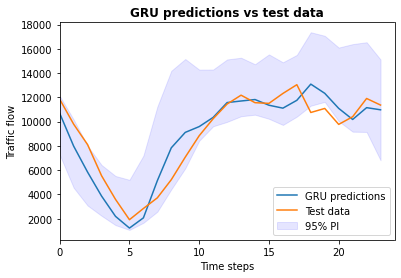

In [ ]:
# GRU model (1HL) predictions vs test data

plt.xlim(0,24)
plt.plot(np.transpose(y_test_pred), label="GRU_predictions")
plt.plot(np.transpose(Y_test), label = "Test data")
plt.fill_between(x = np.arange(0,24), y1= np.transpose(lower_pred).reshape(24), y2=np.transpose(upper_pred).reshape(24), color = "b", alpha = 0.10)

# axis labels, title and legend
plt.xlabel('Time steps')
plt.ylabel("Traffic flow")
plt.title("GRU predictions vs test data", fontweight="bold")
legend = plt.legend(["GRU predictions","Test data","95% PI"],loc='lower right')

#save_results_to = '/Users/Manu/Dropbox/MScThesis-Conor-Manu/Latex/'
#tkz.save(save_results_to + "GRU_predictions.tex")

plt.show()


plot single PI network

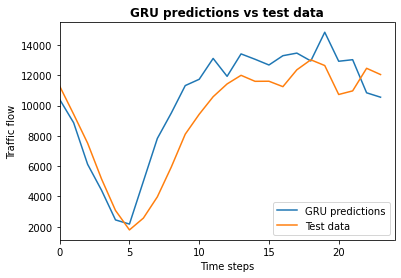

In [ ]:
# GRU model (1HL) predictions vs test data

plt.xlim(0,24)
plt.plot(np.transpose(y_test_pred), label="GRU_predictions")
plt.plot(np.transpose(Y_test), label = "Test data")
#plt.fill_between(x = np.arange(0,24), y1= lower_PI_preds_95, y2= upper_PI_preds_95, color = 'xkcd:sky blue')

# axis labels, title and legend
plt.xlabel('Time steps')
plt.ylabel("Traffic flow")
plt.title("GRU predictions vs test data", fontweight="bold")
legend = plt.legend(["GRU predictions","Test data","95% PI"],loc='lower right')

#save_results_to = '/Users/Manu/Dropbox/MScThesis-Conor-Manu/Latex/'
#tkz.save(save_results_to + "GRU_predictions.tex")

plt.show()


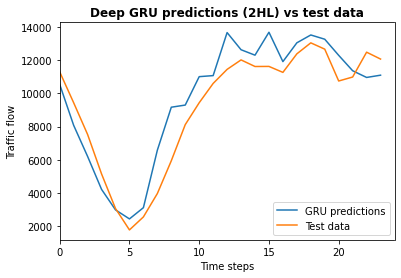

In [ ]:
# Deep GRU model (2HL) predictions vs test data (1 PI network)

plt.xlim(0,24)
plt.plot(np.transpose(y_test_pred_deep), label="Deep GRU_predictions")
plt.plot(np.transpose(Y_test), label = "Test data")
#plt.fill_between(x = np.arange(0,24), y1= lower_PI_preds_2HL_95, y2= upper_PI_preds_2HL_95, color = 'xkcd:sky blue')

# axis labels, title and legend
plt.xlabel('Time steps')
plt.ylabel("Traffic flow")
plt.title("Deep GRU predictions (2HL) vs test data", fontweight="bold")
legend = plt.legend(["GRU predictions","Test data","95% PI"],loc='lower right')

#save_results_to = '/Users/Manu/Dropbox/MScThesis-Conor-Manu/Latex/'
#tkz.save(save_results_to + "GRU_predictions.tex")

plt.show()

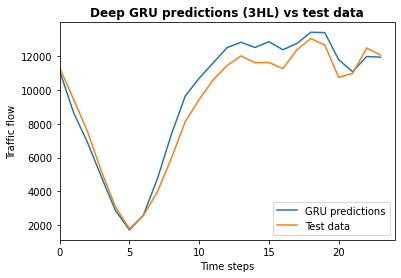

In [ ]:
# Deep GRU model (3HL) predictions vs test data

plt.xlim(0,24)
plt.plot(np.transpose(y_test_pred_deep3hl), label="Deep GRU_predictions")
plt.plot(np.transpose(Y_test), label = "Test data")
#plt.fill_between(x = np.arange(0,24), y1= np.transpose(lower_pred_dgru3).reshape(24), y2=np.transpose(upper_pred_dgru3).reshape(24), color = "b", alpha = 0.10)

# axis labels, title and legend
plt.xlabel('Time steps')
plt.ylabel("Traffic flow")
plt.title("Deep GRU predictions (3HL) vs test data", fontweight="bold")
legend = plt.legend(["GRU predictions","Test data","95% PI"],loc='lower right')

#save_results_to = '/Users/Manu/Dropbox/MScThesis-Conor-Manu/Latex/'
#tkz.save(save_results_to + "GRU_predictions.tex")

plt.show()

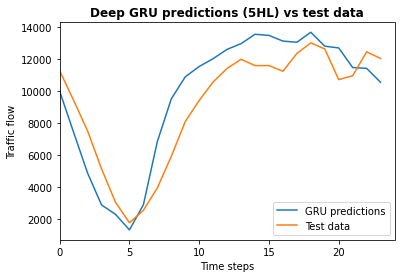

In [ ]:
# Deep GRU model (5HL) predictions vs test data

plt.xlim(0,24)
plt.plot(np.transpose(y_test_pred_deep3), label="Deep GRU_predictions")
plt.plot(np.transpose(Y_test), label = "Test data")
#plt.fill_between(x = np.arange(0,24), y1= np.transpose(lower_pred).reshape(24), y2=np.transpose(upper_pred).reshape(24), color = "b", alpha = 0.10)

# axis labels, title and legend
plt.xlabel('Time steps')
plt.ylabel("Traffic flow")
plt.title("Deep GRU predictions (5HL) vs test data", fontweight="bold")
legend = plt.legend(["GRU predictions","Test data","95% PI"],loc='lower right')

#save_results_to = '/Users/Manu/Dropbox/MScThesis-Conor-Manu/Latex/'
#tkz.save(save_results_to + "GRU_predictions.tex")

plt.show()

In [ ]:
# transposing the predictions

#GRU_preds = np.transpose(y_test_pred)
#GRU_preds_deep = np.transpose(y_test_pred_deep)


# Creating a dataframe with GRU predictions and test data
GRU_change_df = pd.DataFrame(np.transpose(y_test_pred))

# adding a column with the test data
GRU_change_df["Deep GRU predictions (2HL)"] = np.transpose(y_test_pred_deep)
GRU_change_df["Deep GRU predictions (3HL)"] = np.transpose(y_test_pred_deep2)
GRU_change_df["Deep GRU predictions (5HL)"] = np.transpose(y_test_pred_deep3)
GRU_change_df["Test data"] = np.transpose(Y_test)


GRU_change_df.columns = ['GRU predictions', "Deep GRU predictions (2HL)", "Deep GRU predictions (3HL)", "Deep GRU predictions (5HL)", 'Test data']

In [ ]:
# export the GRU predictions and the test data to google drive
from google.colab import  drive

drive.mount('/drive')

GRU_df.to_csv('/drive/My Drive/Colab Notebooks/GRU_preds.csv', index=False)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
